<a href="https://colab.research.google.com/github/wesmail/HADES_Hydra/blob/master/LambdaSelectionTrainingPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## $\Lambda$ Identification using deep learing for p(4.5GeV)+p in HADES

Some important import statements

In [1]:
import torch
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.cm as cm
import sklearn.metrics as metrics
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print ('Training on GPU')
else: print ('Training on CPU')

Training on GPU


In [3]:
path = 'https://raw.githubusercontent.com/wesmail/HADES_Hydra/master/AI/'

In [4]:
def load_events():
    signal = pd.read_csv(path+'Signal_ascii.csv', index_col=0)
    backgd = pd.read_csv(path+'Background_ascii.csv', index_col=0)
    
    signal['label'] = np.ones(signal.shape[0])
    backgd['label'] = np.zeros(backgd.shape[0])
    
    signal_train, signal_test = train_test_split(signal, test_size=0.2)
    backgd_train, backgd_test = train_test_split(backgd, test_size=0.2)
    
    return pd.concat([signal_train, backgd_train], ignore_index=True), \
           pd.concat([signal_test, backgd_test], ignore_index=True)

### Label 1 are signal events $p(4.5GeV) \rightarrow pK^{+}\Lambda$  
### Label 0 are background events $p(4.5GeV) \rightarrow pp\pi^{+}\pi^{-}$

In [5]:
train, test = load_events()
print ('Dataframe of the signal and background: \n', train.head(5))
print ()
print ('\nTotal number of training signal events: ', train.loc[train.label==1].shape[0])
print ('Total number of training background events: ', train.loc[train.label==0].shape[0])
print ()

Dataframe of the signal and background: 
         ppx       ppy      ppz       pe      pipx      pipy      pipz  \
0 -0.517709 -0.418530  1.18820  1.65390 -0.004685 -0.075983  0.069727   
1 -0.544599  0.596033  2.00347  2.35502 -0.198706  0.174743  0.690014   
2 -0.116115 -0.631515  1.47565  1.86284 -0.004490 -0.075261  0.064422   
3 -0.079693 -0.355915  1.25048  1.60533 -0.093328 -0.098659  0.131415   
4 -0.628547 -0.301727  2.29557  2.57607 -0.125195 -0.183788  0.438240   

        pie     d_ppi  d_p_pvtx  d_pi_pvtx  d_svtx_pvtx       pva      d_l  \
0  0.173604   4.00801   17212.4    17283.1      17313.5  1.474550  17233.4   
1  0.752077   1.44749   14469.3    14789.2      17346.8  0.995267  14552.3   
2  0.171218  11.47650   16715.6    17252.0      17321.9  1.324220  16798.0   
3  0.234936   5.49501   16135.5    17055.1      17338.1  1.263960  16528.4   
4  0.510869   2.15898   16339.7    17161.7      17416.6  1.247350  16513.4   

      alpha       q_t        oa       ml  label  


#### Plot the variables used in the training

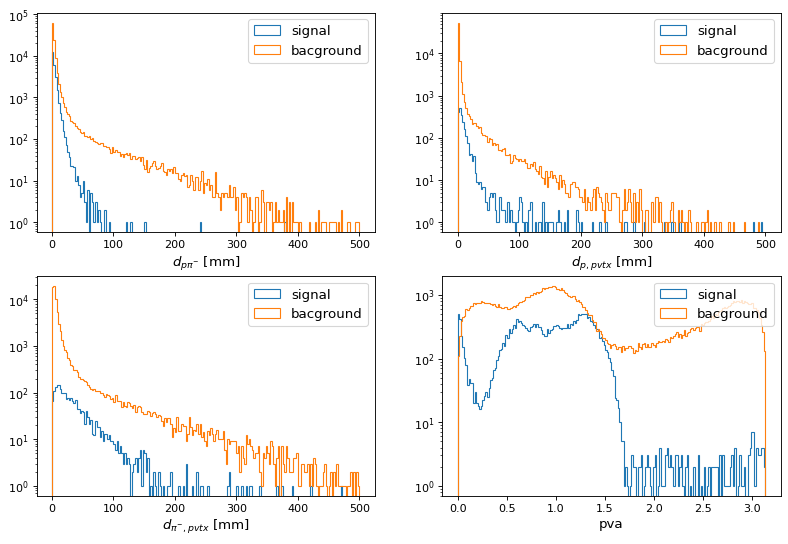

In [6]:
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_ppi, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.label==0].d_ppi, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{p\pi^{-}}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].d_p_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.label==0].d_p_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{p, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].d_pi_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.label==0].d_pi_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{\pi^{-}, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].pva, histtype='step', bins=200, label='signal', range=(0,3.14))
plt.hist(df.loc[df.label==0].pva, histtype='step', bins=200, label='bacground', range=(0,3.14))
plt.xlabel(r'pva', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)


plt.show()

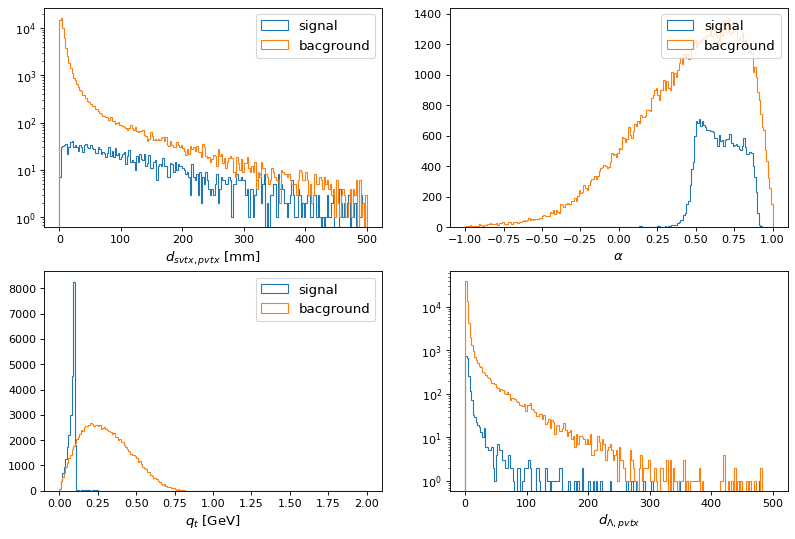

In [7]:
fig = plt.figure(figsize=(12, 8), dpi=80)

plt.subplot(2, 2, 1)
plt.hist(df.loc[df.label==1].d_svtx_pvtx, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.label==0].d_svtx_pvtx, histtype='step', bins=200, label='bacground', range=(0,500))
plt.xlabel(r'$d_{svtx, pvtx}$ [mm]', fontsize=12)
plt.semilogy()
plt.legend(fontsize=12)

plt.subplot(2, 2, 4)
plt.hist(df.loc[df.label==1].d_l, histtype='step', bins=200, label='signal', range=(0,500))
plt.hist(df.loc[df.label==0].d_l, histtype='step', bins=200, label='bacground', range=(0,500))
plt.semilogy()
plt.xlabel(r'$d_{\Lambda, pvtx}$', fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(df.loc[df.label==1].alpha, histtype='step', bins=200, label='signal', range=(-1,1))
plt.hist(df.loc[df.label==0].alpha, histtype='step', bins=200, label='bacground', range=(-1,1))
plt.xlabel(r'$\alpha$', fontsize=12)
plt.legend(fontsize=12)

plt.subplot(2, 2, 3)
plt.hist(df.loc[df.label==1].q_t, histtype='step', bins=200, label='signal', range=(0,2))
plt.hist(df.loc[df.label==0].q_t, histtype='step', bins=200, label='bacground', range=(0,2))
plt.xlabel(r'$q_{t}$ [GeV]', fontsize=12)
plt.legend(fontsize=12)



plt.show()

#### The Armenteros Plot for the $\Lambda$ candidates
This is a two dimensional plot, of transverse momentum $p_{T}$ of the oppositely charged decay products with respect to the $V_{0}$ versus the longitudinal momentum asymmetry $\alpha$

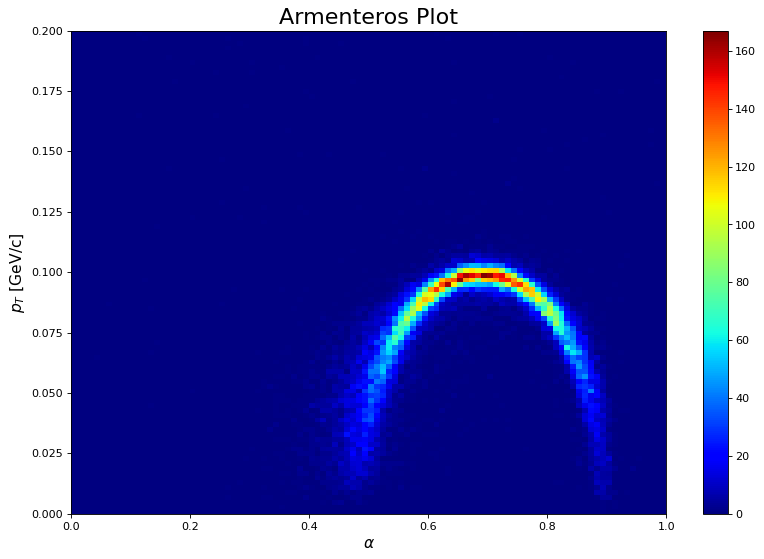

In [8]:
fig = plt.figure(figsize=(12, 8), dpi=80)
_ = plt.hist2d(df.loc[df.label==1].alpha, df.loc[df.label==1].q_t, bins=(100, 100), range=[[0, 1], [0, 0.2]], cmap=plt.cm.jet)
plt.xlabel(r'$\alpha$', fontsize=14)
plt.ylabel(r'$p_{T}$ [GeV/c]', fontsize=14)
plt.title('Armenteros Plot', fontsize=20)
plt.colorbar()

#### Create the training dataset class

In [9]:
class LambdaDataset(Dataset):
    '''Create Training Dataset'''

    def __init__(self, data=None):     
        self.__df          = data
        self.__X, self.__y = self.__items()
    
    def __items(self, verbose=False):
        # select features for training
        df = self.__df[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t','label']]
        
        scale = np.array([100., 100., 100., 1., 100., 1., 1.])
        
        # randomly split the training set
        X_train, _ , y_train, _ = train_test_split(df.iloc[:,0:-1], df.iloc[:,-1], \
                                                   test_size=0.05, random_state=42)
        
        X_train = X_train.to_numpy()/scale
        
        # now scale your data using the StandardScaler
        #scaler  = StandardScaler()
        #X_train = scaler.fit_transform(X_train)
        y_train = y_train.to_numpy()
        
        return X_train, y_train
    
    def __len__(self):
        return len(self.__X)
    
    def getX(self):
        return self.__X
    
    def gety(self):
        return self.__y    
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.__X[idx]), torch.FloatTensor([self.__y[idx]])    

In [10]:
# create the training dataset
train_data = LambdaDataset(data=train)
test_data = LambdaDataset(data=test)

In [11]:
# for balancing the dataset
# making the number of label 1 signal events
# equal to the number of label 0 background events
# by introducing a weight in the loss function
All = train_data.gety().astype(int)
_df = pd.DataFrame(All, columns=['labels'])
labels_unique, counts = np.unique(_df['labels'], return_counts=True)

class_weights = [sum(counts)/c for c in counts]
weights = [class_weights[e] for e in _df['labels']]
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(_df))

# define the batch_size
batch_size = int(8*1024)
print ('Number of data batches: ', len(train_data)/batch_size)

Number of data batches:  15.8851318359375


In [13]:
# sample data according to the batch_size
data_loader = DataLoader(train_data, batch_size=batch_size, num_workers=0, drop_last=True, sampler=sampler)

#### A simple feed-foward neural network with dropout layers

In [12]:
# input shape
shape = train_data.getX().shape[1]

# define a simple sequential model
model = nn.Sequential(nn.Linear(shape, 128),
                      nn.Tanh(),
                      nn.Dropout(0.1),
                      nn.Linear(128, 64),
                      nn.Tanh(),
                      nn.Dropout(0.1),
                      nn.Linear(64, 32),
                      nn.Tanh(),
                      nn.Dropout(0.1),                    
                      nn.Linear(32, 1),
                      nn.Sigmoid())

model = model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)


In [14]:
# create an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# define the loss function
criterion = nn.BCELoss()

#### Train the network

In [15]:
# run the main training loop
total_step = len(data_loader)

num_epochs = 10
accuracy = []
lossval = []


for epoch in range(num_epochs):
    correct_train = 0
    total_train = 0
    loss_batch = 0
    accuracy_batch = 0
    for i_batch, (inputs, labels) in enumerate(data_loader):
        #labels = labels.view(-1,1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
      
        labels = labels.view(-1)
        total_train += labels.size(0)        
        predicted = torch.round(outputs).view(-1)
        correct_train += (predicted == labels).sum().item()
        
        accuracy_batch += correct_train/total_train
        loss_batch += loss.item()
        
        if (i_batch+1) % 10 == 0:
            print ('epoch [{}/{}], step [{}/{}], loss: {:.3f}, acc: {:.3f}'\
                   .format(epoch+1, num_epochs, i_batch+1, total_step, loss.item(), (correct_train/total_train) ))
    
    accuracy.append(accuracy_batch/batch_size)
    lossval.append(loss_batch/batch_size)

epoch [1/10], step [10/15], loss: 0.467, acc: 0.750
epoch [2/10], step [10/15], loss: 0.380, acc: 0.841
epoch [3/10], step [10/15], loss: 0.363, acc: 0.848
epoch [4/10], step [10/15], loss: 0.356, acc: 0.852
epoch [5/10], step [10/15], loss: 0.348, acc: 0.854
epoch [6/10], step [10/15], loss: 0.373, acc: 0.856
epoch [7/10], step [10/15], loss: 0.341, acc: 0.857
epoch [8/10], step [10/15], loss: 0.338, acc: 0.861
epoch [9/10], step [10/15], loss: 0.314, acc: 0.865
epoch [10/10], step [10/15], loss: 0.360, acc: 0.858


#### Plot the learning curve

(0.0, 1.0)

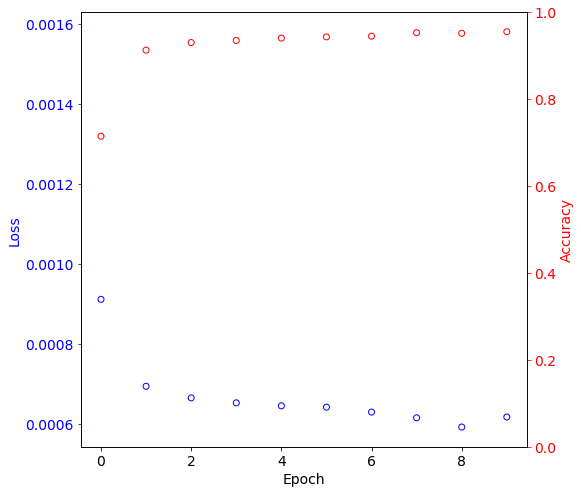

In [16]:
fig, ax1 = plt.subplots(figsize=(8,8),facecolor='w')
line13 = ax1.scatter(np.arange(num_epochs), lossval, label='loss',
                     facecolors='none', edgecolors='blue',marker='o')

ax1.set_xlabel('Epoch',fontsize=14,color='black')
ax1.tick_params('x',colors='black',labelsize=14)
ax1.set_ylabel('Loss', fontsize=14,color='b')
ax1.tick_params('y',colors='b',labelsize=14)

ax2 = ax1.twinx()
line23 = ax1.scatter(np.arange(num_epochs), accuracy, label='accuracy',
                     facecolors='none', edgecolors='red',marker='o')


ax2.set_ylabel('Accuracy', fontsize=14,color='r')
ax2.tick_params('y',colors='r',labelsize=14)
ax2.set_ylim(0.,1.0)

### The ROC curve

In [17]:
# move the model to the CPU
model_cpu = copy.deepcopy(model)
model_cpu = model_cpu.cpu()
model_cpu.eval()

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): Tanh()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=32, out_features=1, bias=True)
  (10): Sigmoid()
)

In [21]:
# save the trained model
#torch.save(model_cpu, 'model.pt')

In [18]:
# calculate the fpr and tpr for all thresholds of the classification
x_test, y_test = test[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t']].to_numpy(), test[['label']]
scale = np.array([100., 100., 100., 1., 100., 1., 1.])
x_test = x_test/scale
# now scale your data using the StandardScaler
#scaler = StandardScaler()
#X_test = scaler.fit_transform(x_test)
y_test = y_test.to_numpy()

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

probs = model_cpu.forward(x_test)
probs = probs.detach().numpy()

Text(0.5, 0, 'False Positive Rate')

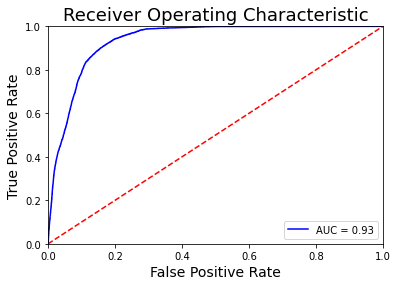

In [19]:
y_hat = probs[:]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_hat)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic', fontsize=18)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)

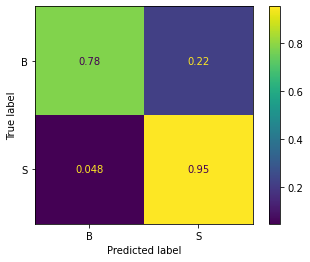

In [20]:
predictions = np.round(model_cpu.forward(x_test).detach().numpy())
cm = confusion_matrix(y_test.detach().numpy().flatten(), predictions.flatten())
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cmn,display_labels=['B','S'])
disp.plot()

### Plot the $p\pi^{-}$ invariant mass for selection of cuts

In [21]:
x_test, y_test = test[['d_ppi','d_p_pvtx','d_pi_pvtx','pva','d_svtx_pvtx', 'alpha','q_t']].to_numpy(), test[['label']]
scale = np.array([100., 100., 100., 1., 100., 1., 1.])
x_test = x_test/scale
y_test = y_test.to_numpy()

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

probs = model_cpu.forward(x_test)
probs = probs.detach().numpy()

test['pred'] = probs

In [23]:
signal, bkg = test.loc[test.label==1].to_numpy(), test.loc[test.label==0].to_numpy()

In [24]:
kcuts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

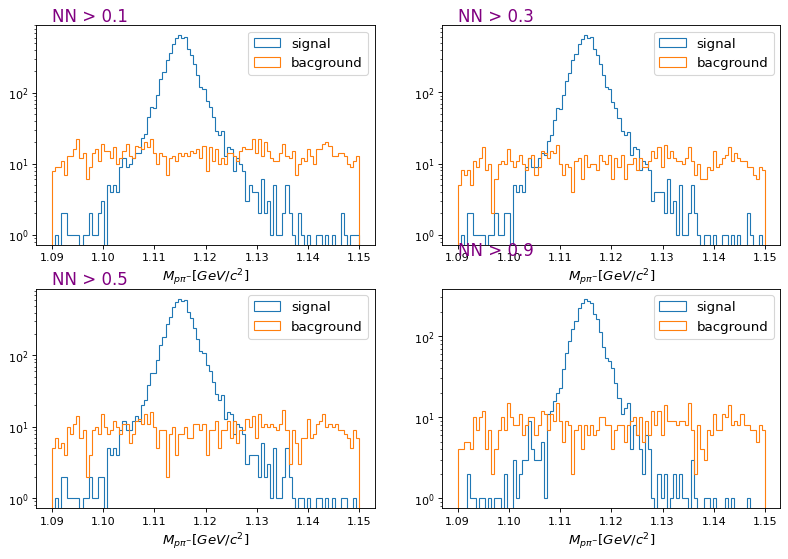

In [25]:
fig = plt.figure(figsize=(12, 8), dpi=80)

df = train

plt.subplot(2, 2, 1)
plt.hist(signal[np.where(signal[:,-1]>kcuts[0])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[0])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.1', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 2)
plt.hist(signal[np.where(signal[:,-1]>kcuts[2])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[2])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.3', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 3)
plt.hist(signal[np.where(signal[:,-1]>kcuts[4])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[4])[0],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.5', size=15, color='purple')
plt.legend(fontsize=12)


plt.subplot(2, 2, 4)
plt.hist(signal[np.where(signal[:,-1]>kcuts[-1])[0],-3], histtype='step', bins=100, label='signal', range=(1.090, 1.15), density=False)
plt.hist(bkg[np.where(bkg[:,-1]>kcuts[6])[-1],-3], histtype='step', bins=100, label='bacground', range=(1.090, 1.15), density=False)
plt.xlabel(r'$M_{p\pi^{-}} [GeV/c^{2}]$', fontsize=12)
plt.semilogy()
plt.text(1.09, 1000, 'NN > 0.9', size=15, color='purple')
plt.legend(fontsize=12)

In [26]:
# plot the signal significance vs NN output
ss = []
for cut in kcuts:
    S = signal[np.where(signal[:,-1]>cut)[0],-3]
    B = bkg[np.where(bkg[:,-1]>cut)[0],-3]
    S = (np.where((S>1.108) & (S<1.122))[0]).shape[0]
    B = (np.where((B>1.108) & (B<1.122))[0]).shape[0]
    
    ss.append(S/np.sqrt(S+B))

Text(0.5, 0, 'NN output')

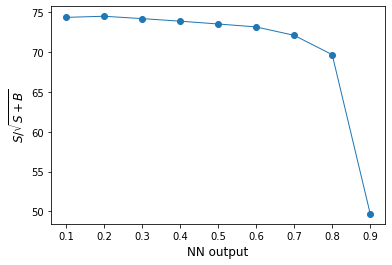

In [27]:
plt.plot(kcuts, ss, linewidth=1)
plt.scatter(kcuts, ss)
plt.ylabel(r'$S/\sqrt{S+B}$', fontsize=12)
plt.xlabel(r'NN output', fontsize=12)